# Skin deep data
There is an increasing number of private companies that are gathering huge amounts of physiological data. The popularization of exercise trackers, smart watches and other devices that are in direct contact with our bodies poses a whole new set of challenges concerning privacy and identity theft. Unlike national health services, these companies aren't subject to the same privacy regulations that hospitals and other health services are and often deploy systems that leave vast amounts of very personal data exposed. Very often the only protection against the misuse of that data is a *terms of service* contract which shifts responsibility to the end user. The shift taking place now is one in which *the patient* becomes a *user*. 

As sensors improve and medical quality data becomes common place in devices used for exercising, data that can uniquely identify people is gathered in data silos that aren't bound to privacy regulations and could result in unreversible privacy violations should those databases be hacked.

### Data for medical use
Medical data is a complex concern  =>  privacy is important  =>  but you do not want that to be an obstacle for a person that could save your life in a live or die scenario. 

In [23]:
%matplotlib inline  # make sure plots are shown in-document
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

# Set some Pandas options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)

def bitalino_printmeta(f):
    for k in f.attrs.keys():
        print k, f.attrs[k]


ecgf = h5py.File('data/day0_ecg_20150212_19h11m37s.h5', 'r')
bitalino_printmeta( ecgf )
ecg_samples = ecgf.attrs['nsamples']

from pytimeparse.timeparse import timeparse
dt = timeparse(ecgf.attrs['duration'])
print "duration in ms: ", dt*1000

device bioPLUX
date 2015-2-12
time 19:6:7
channels ['3']
fs ['1000']
nbits ['10']
macaddress 98:D3:31:B2:C0:D6
firmware version 
hardware version 111
comments 
video_src 
video_sync -1
video_fps -1
nsamples 313896
lock_Dig_Port 1
duration 5m13s
duration in ms:  313000


### Heart rate during regular activity

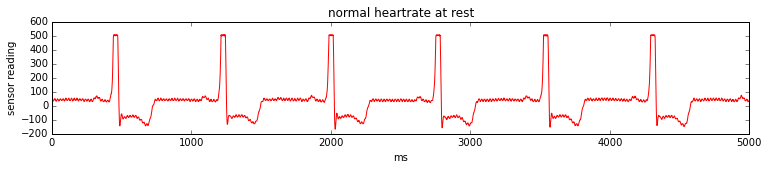

In [29]:
# covert data from ECG data file to a numpy array
ecg = np.asarray(ecgf['/raw/channel_3'], 'int32')

ts = (ecg[:,0]-512)
ts = ts[0:5000] # slice first 5k ms

# build timeseries from array slice
ecgts = pd.Series(data=ts)
plt.figure(1, figsize=(12.5,2), dpi=100)
plt.title('normal heartrate at rest')
plt.ylabel('sensor reading')
plt.xlabel('ms')

plt.plot(ecgts, 'r-')
plt.show()

### Scrambler
The scrambler is a small device that is applied topically on the skin, near the region where ECG sensors are placed. The scrambler works by picking up the heart's tiny electrical signal and encoding it before sending it to the sensors.

### Scrambled heartrate data
Data obtained from a ECG sensors appears random to the naked eye, the original measurement of the hearts electrical activity is still there but it is buried beneath a unifrm layer of noise that can only be removed by unscrambling it.

To unscramble this data it is necessary that the owner of this data enters the PIN in the unscrambler.

In [30]:
import struct

def inta2bin(arr):
    """ convert array of ints to a binary string """
    bstr = ''
    for e in arr:
        bstr += struct.pack('i', e)
    return bstr

def bin2inta(bstr):
    """ convert a binary string to an array of ints """
    return struct.unpack_from('i'*(len(bstr)/4), bstr)

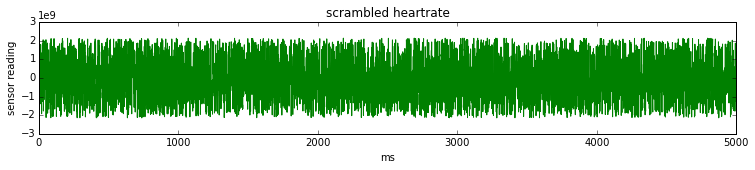

In [31]:
from Crypto.Cipher import AES

# encrypt timeseries of signal
secret_key = "0123456789abcdef"

tsstream = inta2bin( ts )
cipher = AES.new(secret_key, AES.MODE_ECB)
encoded = cipher.encrypt(tsstream)
tsencoded = bin2inta(encoded)

plt.figure(2, figsize=(12.5,2), dpi=100)
plt.title('scrambled heartrate')
plt.ylabel('sensor reading')
plt.xlabel('ms')

encsignal = pd.Series( tsencoded )
plt.plot(encsignal, 'g-')  # 'g-' stands for "green lines"
plt.show()

### Comparison with random data
Let's see what a random time series would look like by comparing it to the scrambled heart rate signal.

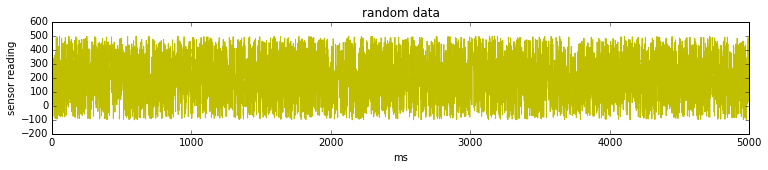

In [32]:
samples_per_second = 1000
seconds = 5

plt.figure(3, figsize=(12.5,2), dpi=100)
plt.title('random data')
plt.ylabel('sensor reading')
plt.xlabel('ms')
plt.ylim(-200.0, 600.0)

signal = pd.Series(np.random.sample(size=samples_per_second*seconds)*600.0-100.0)
plt.plot(signal, 'y-')  # 'g-' stands for "green lines"
plt.xticks( np.arange(0, seconds*samples_per_second+1, 1000) )
plt.show()

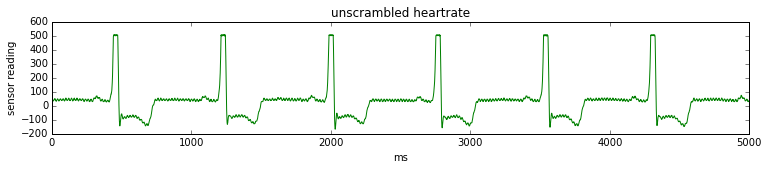

In [33]:
decoded = cipher.decrypt(encoded)
tsdecoded = bin2inta(decoded)

plt.figure(4, figsize=(12.5,2), dpi=100)
plt.title('unscrambled heartrate')
plt.ylabel('sensor reading')
plt.xlabel('ms')

encsignal = pd.Series( tsdecoded )
plt.plot(encsignal, 'g-')  # 'g-' stands for "green lines"
plt.show()